In [41]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

import re 
import string 
import json 
import requests
import ast

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud 


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

from surprise import SVD, Reader, Dataset 
from surprise.model_selection import cross_validate

In [42]:
reviews = pd.read_csv(r'.data/rt.reviews.tsv',delimiter='\t', encoding='unicode_escape')
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [43]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [44]:
# Assuming your DataFrame is called 'reviews' and the column is 'rating'
reviews['rating'] = pd.to_numeric(reviews['rating'], errors='coerce')
# reviews.dropna(subset=['rating'], inplace=True)

In [45]:
reviews['rating'].value_counts()

rating
8.0    143
1.0    139
7.0    125
6.0     82
5.0     48
3.0     35
4.0     35
9.0     34
3.5     18
2.0     11
2.5      8
2.7      8
0.0      6
3.7      5
1.5      5
2.2      5
4.5      5
3.2      3
4.7      3
4.8      2
8.2      2
9.8      2
3.4      2
5.8      2
3.3      1
6.2      1
7.8      1
3.1      1
9.2      1
7.4      1
9.7      1
4.1      1
8.5      1
1.8      1
5.9      1
5.2      1
6.7      1
7.9      1
1.7      1
8.9      1
8.4      1
4.2      1
7.3      1
4.9      1
7.7      1
7.1      1
Name: count, dtype: int64

In [46]:
reviews.shape

(54432, 8)

In [47]:
# Creating a new column containing the sentiments from the rating. 

def group_ratings(df, ratings, sentiment, threshold):
    # create an empty column to store the sentiments
    df[sentiment] = ''
    
    # create threshhold for sentiment
    #threshold = 0.6
    
    # assign the sentiment based on the threshold
    df.loc[df[ratings] >= threshold, sentiment] = 'Positive'
    df.loc[df[ratings] < threshold, sentiment] = 'Negative'
    
    return df

In [48]:
# Appplying the function above
df = group_ratings(reviews, 'rating', 'sentiment', 0.6)

In [49]:
df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,sentiment
0,3,A distinctly gallows take on contemporary fina...,NaN,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",


In [50]:
reviews[['review', 'sentiment']]

,review,sentiment
0,A distinctly gallows take on contemporary fina...,
1,It's an allegory in search of a meaning that n...,
2,... life lived in a bubble in financial dealin...,
3,Continuing along a line introduced in last yea...,
4,... a perverse twist on neorealism...,
...,...,...
54427,The real charm of this trifle is the deadpan c...,
54428,NaN,
54429,NaN,
54430,NaN,


In [51]:
df.isnull().count()

id            54432
review        54432
rating        54432
fresh         54432
critic        54432
top_critic    54432
publisher     54432
date          54432
sentiment     54432
dtype: int64

In [52]:
movies = pd.read_csv(r'.data/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [53]:
movies.shape

(9742, 3)

In [54]:
ratings = pd.read_csv(r'.data/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [55]:
ratings.shape

(100836, 4)

In [56]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [57]:
ratings['timestamp']

0        2000-07-30 18:45:03
1        2000-07-30 18:20:47
2        2000-07-30 18:37:04
3        2000-07-30 19:03:35
4        2000-07-30 18:48:51
                 ...        
100831   2017-05-03 21:53:22
100832   2017-05-03 22:21:31
100833   2017-05-08 19:50:47
100834   2017-05-03 21:19:12
100835   2017-05-03 21:20:15
Name: timestamp, Length: 100836, dtype: datetime64[ns]

In [58]:
ratings['date'] = pd.to_datetime(ratings['timestamp'], yearfirst=True).dt.date
ratings['time'] = pd.to_datetime(ratings['timestamp'], format = '%H/%M/%S/%MS').dt.time

In [59]:
ratings.head()

,userId,movieId,rating,timestamp,date,time
0,1,1,4.0,2000-07-30 18:45:03,2000-07-30,18:45:03
1,1,3,4.0,2000-07-30 18:20:47,2000-07-30,18:20:47
2,1,6,4.0,2000-07-30 18:37:04,2000-07-30,18:37:04
3,1,47,5.0,2000-07-30 19:03:35,2000-07-30,19:03:35
4,1,50,5.0,2000-07-30 18:48:51,2000-07-30,18:48:51


In [60]:
ratings.shape

(100836, 6)

In [61]:
ratings = group_ratings(ratings, 'rating', 'sentiment', 0.6)

In [62]:
ratings.head()

,userId,movieId,rating,timestamp,date,time,sentiment
0,1,1,4.0,2000-07-30 18:45:03,2000-07-30,18:45:03,Positive
1,1,3,4.0,2000-07-30 18:20:47,2000-07-30,18:20:47,Positive
2,1,6,4.0,2000-07-30 18:37:04,2000-07-30,18:37:04,Positive
3,1,47,5.0,2000-07-30 19:03:35,2000-07-30,19:03:35,Positive
4,1,50,5.0,2000-07-30 18:48:51,2000-07-30,18:48:51,Positive


In [63]:
tags = pd.read_csv(r'.data/tags.csv')
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [64]:
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

In [65]:
tags['date'] = pd.to_datetime(tags['timestamp'], yearfirst=True).dt.date
tags['time'] = pd.to_datetime(tags['timestamp'], format = '%H/%M/%S/%MS').dt.time

In [66]:
tags.head()

,userId,movieId,tag,timestamp,date,time
0,2,60756,funny,2015-10-24 19:29:54,2015-10-24,19:29:54
1,2,60756,Highly quotable,2015-10-24 19:29:56,2015-10-24,19:29:56
2,2,60756,will ferrell,2015-10-24 19:29:52,2015-10-24,19:29:52
3,2,89774,Boxing story,2015-10-24 19:33:27,2015-10-24,19:33:27
4,2,89774,MMA,2015-10-24 19:33:20,2015-10-24,19:33:20


### Mergings

In [67]:
# Joining ratings and Tags into one dataframe along the userID column
tagratings = ratings.merge(tags, how='outer', on='movieId')

In [68]:
tagratings.head()

,userId_x,movieId,rating,timestamp_x,date_x,time_x,sentiment,userId_y,tag,timestamp_y,date_y,time_y
0,1.0,1,4.0,2000-07-30 18:45:03,2000-07-30,18:45:03,Positive,336.0,pixar,2006-02-04 09:36:04,2006-02-04,09:36:04
1,1.0,1,4.0,2000-07-30 18:45:03,2000-07-30,18:45:03,Positive,474.0,pixar,2006-01-14 02:47:05,2006-01-14,02:47:05
2,1.0,1,4.0,2000-07-30 18:45:03,2000-07-30,18:45:03,Positive,567.0,fun,2018-05-02 18:33:33,2018-05-02,18:33:33
3,5.0,1,4.0,1996-11-08 06:36:02,1996-11-08,06:36:02,Positive,336.0,pixar,2006-02-04 09:36:04,2006-02-04,09:36:04
4,5.0,1,4.0,1996-11-08 06:36:02,1996-11-08,06:36:02,Positive,474.0,pixar,2006-01-14 02:47:05,2006-01-14,02:47:05


In [69]:
tagratings.shape

(285783, 12)

In [70]:
tagratings.duplicated(subset='movieId').sum()

276041

In [71]:
tagratings = tagratings.drop_duplicates(subset='movieId')

In [72]:
tagratings.duplicated().sum()

0

In [73]:
tagratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9742 entries, 0 to 285782
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   userId_x     9724 non-null   float64       
 1   movieId      9742 non-null   int64         
 2   rating       9724 non-null   float64       
 3   timestamp_x  9724 non-null   datetime64[ns]
 4   date_x       9724 non-null   object        
 5   time_x       9724 non-null   object        
 6   sentiment    9724 non-null   object        
 7   userId_y     1572 non-null   float64       
 8   tag          1572 non-null   object        
 9   timestamp_y  1572 non-null   datetime64[ns]
 10  date_y       1572 non-null   object        
 11  time_y       1572 non-null   object        
dtypes: datetime64[ns](2), float64(3), int64(1), object(6)
memory usage: 989.4+ KB


In [74]:
tagratings.shape

(9742, 12)

In [75]:
movtagrats = movies.merge(tagratings, how='outer', on='movieId')
movtagrats.head()

,movieId,title,genres,userId_x,rating,timestamp_x,date_x,time_x,sentiment,userId_y,tag,timestamp_y,date_y,time_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03,2000-07-30,18:45:03,Positive,336.0,pixar,2006-02-04 09:36:04,2006-02-04,09:36:04
1,2,Jumanji (1995),Adventure|Children|Fantasy,6.0,4.0,1996-10-17 11:58:42,1996-10-17,11:58:42,Positive,62.0,fantasy,2018-06-12 22:52:09,2018-06-12,22:52:09
2,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30 18:20:47,2000-07-30,18:20:47,Positive,289.0,moldy,2006-03-27 02:01:00,2006-03-27,02:01:00
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,6.0,3.0,1996-10-17 12:12:29,1996-10-17,12:12:29,Positive,NaN,NaN,NaT,NaN,NaN
4,5,Father of the Bride Part II (1995),Comedy,6.0,5.0,1996-10-17 12:05:38,1996-10-17,12:05:38,Positive,474.0,pregnancy,2006-01-16 01:11:43,2006-01-16,01:11:43


In [76]:
movtagrats.shape

(9742, 14)

In [77]:
movtagrats.describe()

,movieId,userId_x,rating,timestamp_x,userId_y,timestamp_y
count,9742.000000,9724.000000,9724.000000,9724,1572.000000,1572
mean,42200.353623,214.491670,3.298026,2009-05-03 20:30:38.970177024,441.489186,2008-05-10 20:48:18.872137472
min,1.000000,1.000000,0.500000,1996-04-17 16:50:09,2.000000,2006-01-13 19:09:12
25%,3248.250000,33.000000,2.500000,2003-03-31 02:03:28.500000,474.000000,2006-01-14 02:35:31.500000
50%,7300.000000,135.000000,3.500000,2009-02-09 14:29:12.500000,474.000000,2006-01-23 16:03:18.500000
75%,76232.000000,387.000000,4.000000,2016-04-09 18:15:13,474.000000,2006-11-29 06:47:23.249999872
max,193609.000000,610.000000,5.000000,2018-09-23 03:55:27,610.000000,2018-09-16 11:49:42
std,52160.494854,199.585586,1.103966,NaN,113.364766,NaN


In [78]:
reviews = reviews.rename(columns={"id": "movieId"})

In [79]:
movies_df = movtagrats.merge(reviews, on='movieId', how='outer')

In [80]:
movies_df.head()

,movieId,title,genres,userId_x,rating_x,timestamp_x,date_x,time_x,sentiment_x,userId_y,...,date_y,time_y,review,rating_y,fresh,critic,top_critic,publisher,date,sentiment_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03,2000-07-30,18:45:03,Positive,336.0,...,2006-02-04,09:36:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji (1995),Adventure|Children|Fantasy,6.0,4.0,1996-10-17 11:58:42,1996-10-17,11:58:42,Positive,62.0,...,2018-06-12,22:52:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30 18:20:47,2000-07-30,18:20:47,Positive,289.0,...,2006-03-27,02:01:00,A distinctly gallows take on contemporary fina...,NaN,fresh,PJ Nabarro,0.0,Patrick Nabarro,"November 10, 2018",
3,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30 18:20:47,2000-07-30,18:20:47,Positive,289.0,...,2006-03-27,02:01:00,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0.0,io9.com,"May 23, 2018",
4,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30 18:20:47,2000-07-30,18:20:47,Positive,289.0,...,2006-03-27,02:01:00,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0.0,Stream on Demand,"January 4, 2018",


In [81]:
# checking for existence of duplicated entries. 
def check_for_duplicates(data):
    # check percentage duplicates
    num_duplicates = data.duplicated().sum()
    total_entries = len(data)
    duplicate_percentage = (num_duplicates / total_entries) * 100
    
    if num_duplicates > 0:
        print(f"There are {num_duplicates} duplicate entries in the dataset.")
        print(f"This accounts for {duplicate_percentage:.2f}% of the total entries.")
    else:
        print("No duplicates found.")

In [82]:
check_for_duplicates(movies_df)

There are 25 duplicate entries in the dataset.
This accounts for 0.04% of the total entries.


In [83]:
def remove_duplicates(data):
    data = data.drop_duplicates(inplace=True)
    return data

In [84]:
remove_duplicates(movies_df)

#### 2.1.2)Finding the Shape of the datasets:
- Info 
- Columns, Column Names
- Datatypes
- Statistcics 

In [86]:
# Function to know the info of the datasets
def create_dataset_info(dataset):
    if isinstance(dataset, pd.DataFrame):
        info = dataset.info()
        return info
    else:
        return "Invalid dataset type. Please provide a Pandas DataFrame."
# Assuming you have a dataset named 'sales_data'
dataset_info = create_dataset_info(movies_df)

print(dataset_info)


<class 'pandas.core.frame.DataFrame'>
Index: 63309 entries, 0 to 63333
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   movieId      63309 non-null  int64         
 1   title        49330 non-null  object        
 2   genres       49330 non-null  object        
 3   userId_x     49312 non-null  float64       
 4   rating_x     49312 non-null  float64       
 5   timestamp_x  49312 non-null  datetime64[ns]
 6   date_x       49312 non-null  object        
 7   time_x       49312 non-null  object        
 8   sentiment_x  49312 non-null  object        
 9   userId_y     14648 non-null  float64       
 10  tag          14648 non-null  object        
 11  timestamp_y  14648 non-null  datetime64[ns]
 12  date_y       14648 non-null  object        
 13  time_y       14648 non-null  object        
 14  review       48867 non-null  object        
 15  rating_y     750 non-null    float64       
 16  fresh    

In [87]:
# Function to know the shape 
def check_dataset_shape(dataset):
    if isinstance(dataset, np.ndarray):
        print("Dataset shape:", dataset.shape)
    elif isinstance(dataset, pd.DataFrame):
        print("Dataset shape:", dataset.shape)
    else:
        print("Invalid dataset type. Please provide a NumPy array or a Pandas DataFrame.")
        
# Assuming you have a dataset named 'sales_data'
check_dataset_shape(movies_df)

Dataset shape: (63309, 22)


In [88]:
# Function to know statistics
def get_dataset_statistics_describe(dataset):
    """
    Function to obtain information about a given dataset.
    
    Args:
    - dataset (pandas.DataFrame): The dataset to get information about.
    
    Returns:
    - None: Prints the information about the dataset.
    """
    dataset_describe = dataset.describe()
    return dataset_describe


# Call the function to get information about the dataset
get_dataset_statistics_describe(movies_df)

,movieId,userId_x,rating_x,timestamp_x,userId_y,timestamp_y,rating_y,top_critic
count,63309.000000,49312.000000,49312.000000,49312,14648.000000,14648,750.000000,54407.000000
mean,7379.596724,126.952405,3.364648,2003-06-14 10:27:20.369626112,457.060964,2007-01-30 07:22:21.118446080,5.135733,0.240704
min,1.000000,1.000000,0.500000,1996-04-17 16:50:09,2.000000,2006-01-13 19:09:12,0.000000,0.000000
25%,612.000000,6.000000,3.000000,1999-10-12 08:27:35,474.000000,2006-01-14 02:21:01,3.000000,0.000000
50%,1235.000000,33.000000,3.500000,2000-08-08 04:13:58,474.000000,2006-01-16 01:17:04,6.000000,0.000000
75%,1762.000000,182.000000,4.000000,2006-10-22 15:27:10,474.000000,2006-01-24 21:19:15,7.775000,0.000000
max,193609.000000,610.000000,5.000000,2018-09-23 03:55:27,610.000000,2018-09-16 11:49:42,9.800000,1.000000
std,25286.994805,178.310429,1.123571,NaN,71.403670,NaN,2.716021,0.427515


In [89]:
movies_df.isnull().sum()

movieId            0
title          13979
genres         13979
userId_x       13997
rating_x       13997
timestamp_x    13997
date_x         13997
time_x         13997
sentiment_x    13997
userId_y       48661
tag            48661
timestamp_y    48661
date_y         48661
time_y         48661
review         14442
rating_y       62559
fresh           8902
critic         11599
top_critic      8902
publisher       9211
date            8902
sentiment_y     8902
dtype: int64

In [90]:
movies_df.columns

Index(['movieId', 'title', 'genres', 'userId_x', 'rating_x', 'timestamp_x',
       'date_x', 'time_x', 'sentiment_x', 'userId_y', 'tag', 'timestamp_y',
       'date_y', 'time_y', 'review', 'rating_y', 'fresh', 'critic',
       'top_critic', 'publisher', 'date', 'sentiment_y'],
      dtype='object')

In [91]:
# Creating a new datset with the columns that we want
columns_to_keep = ['movieId', 'title', 'genres', 'userId_x', 'rating_x',
       'date_x', 'time_x', 'sentiment_x', 'review', 'tag', 'top_critic', 'publisher', 'date' ]
movies_credits = movies_df.loc[:, columns_to_keep]
movies_credits.head()

,movieId,title,genres,userId_x,rating_x,date_x,time_x,sentiment_x,review,tag,top_critic,publisher,date
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30,18:45:03,Positive,NaN,pixar,NaN,NaN,NaN
1,2,Jumanji (1995),Adventure|Children|Fantasy,6.0,4.0,1996-10-17,11:58:42,Positive,NaN,fantasy,NaN,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30,18:20:47,Positive,A distinctly gallows take on contemporary fina...,moldy,0.0,Patrick Nabarro,"November 10, 2018"
3,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30,18:20:47,Positive,It's an allegory in search of a meaning that n...,moldy,0.0,io9.com,"May 23, 2018"
4,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30,18:20:47,Positive,... life lived in a bubble in financial dealin...,moldy,0.0,Stream on Demand,"January 4, 2018"


Saving the dataset for use in the main notebook

In [104]:
# Save the dataset to a CSV file
movies_credits.to_csv('.data/movies_lens.csv', index=False)

### 2.1.3)Data Scrubbing

further understanging of the dataset. 

In [93]:
movies_credits = movies_credits.rename(columns={"userId_x":"userId", "rating_x": "rating", "timestamp_x":"timestamp", "date_x": "date", "time_x": "time", "sentiment_x": "sentiment"})

In [94]:
movies_credits.head()

,movieId,title,genres,userId,rating,date,time,sentiment,review,tag,top_critic,publisher,date
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30,18:45:03,Positive,NaN,pixar,NaN,NaN,NaN
1,2,Jumanji (1995),Adventure|Children|Fantasy,6.0,4.0,1996-10-17,11:58:42,Positive,NaN,fantasy,NaN,NaN,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30,18:20:47,Positive,A distinctly gallows take on contemporary fina...,moldy,0.0,Patrick Nabarro,"November 10, 2018"
3,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30,18:20:47,Positive,It's an allegory in search of a meaning that n...,moldy,0.0,io9.com,"May 23, 2018"
4,3,Grumpier Old Men (1995),Comedy|Romance,1.0,4.0,2000-07-30,18:20:47,Positive,... life lived in a bubble in financial dealin...,moldy,0.0,Stream on Demand,"January 4, 2018"


In [95]:
movies_credits.shape

(63309, 13)

In [96]:
movies_credits.isnull().sum()

movieId           0
title         13979
genres        13979
userId        13997
rating        13997
date          13997
time          13997
sentiment     13997
review        14442
tag           48661
top_critic     8902
publisher      9211
date           8902
dtype: int64

In [97]:
movies_credits = movies_credits.dropna(subset=['rating', 'tag', 'review', 'publisher' ])

In [98]:
movies_credits.shape

(11970, 13)

In [99]:
movies_credits.isnull().sum()

movieId       0
title         0
genres        0
userId        0
rating        0
date          0
time          0
sentiment     0
review        0
tag           0
top_critic    0
publisher     0
date          0
dtype: int64

In [100]:
# For the genres column we have to convert it but first we have to implement 
movies_credits.iloc[0].genres

'Comedy|Romance'

In [101]:
#Fourth KPI
#Genre-specific subsets:

# Action
action_movies = movies_credits[movies_credits['genres'].str.contains('Action')]

# Adventure
adventure_movies = movies_credits[movies_credits['genres'].str.contains('Adventure')]

# Animation
animation_movies = movies_credits[movies_credits['genres'].str.contains('Animation')]

# Comedy
comedy_movies = movies_credits[movies_credits['genres'].str.contains('Comedy')]

# Crime
crime_movies = movies_credits[movies_credits['genres'].str.contains('Crime')]

# Documentary
documentary_movies = movies_credits[movies_credits['genres'].str.contains('Documentary')]

# Drama
drama_movies = movies_credits[movies_credits['genres'].str.contains('Drama')]

# Family
family_movies = movies_credits[movies_credits['genres'].str.contains('Family')]

# Fantasy
fantasy_movies = movies_credits[movies_credits['genres'].str.contains('Fantasy')]

# History
children_movies = movies_credits[movies_credits['genres'].str.contains('Children')]

# Horror
horror_movies = movies_credits[movies_credits['genres'].str.contains('Horror')]

# Music
music_movies = movies_credits[movies_credits['genres'].str.contains('Music', 'Musical')]

# Mystery
mystery_movies = movies_credits[movies_credits['genres'].str.contains('Mystery')]

# Romance
romance_movies = movies_credits[movies_credits['genres'].str.contains('Romance')]

# Science Fiction
sci_fi_movies = movies_credits[movies_credits['genres'].str.contains('Sci-Fi')]

# Thriller
thriller_movies = movies_credits[movies_credits['genres'].str.contains('Thriller')]

# War
war_movies = movies_credits[movies_credits['genres'].str.contains('War')]

# Western
western_movies = movies_credits[movies_credits['genres'].str.contains('Western')]


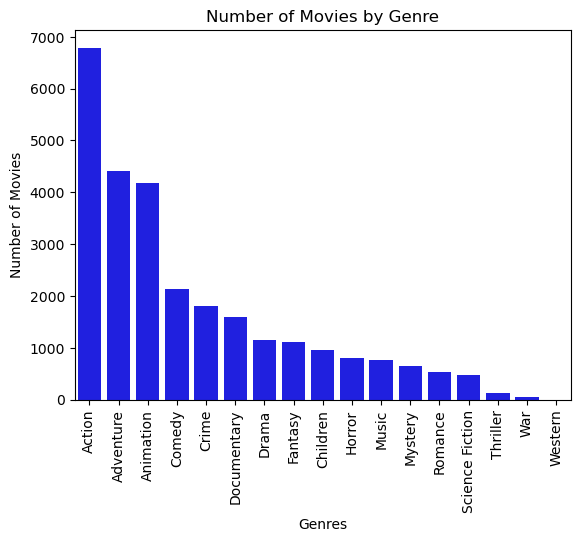

In [102]:


#first, we Create a list of all genres
counts = []
genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
            'Documentary', 'Drama', 'Fantasy', 'Children', 
            'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 
            'Thriller', 'War', 'Western']

for genre in genres:
    genre_movies = movies_credits[movies_credits['genres'].apply(lambda x: genre in x)]
    counts.append(len(genre_movies))
    
# Sort the counts in descending order
sorted_counts = sorted(counts, reverse=True)
    
# Create the bar plot using Seaborn
ax = sns.barplot(x=genres, y=sorted_counts, color='b', order=genres)

# Customize the plot
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Genre')
plt.xticks(rotation=90)


# Show the plot
plt.show()

## 3)Recommendation System 
##  i ) Demographic Recommendation:
### - Rating
##### Sort The movie/credits based on ratings and display the top movies: Improve accuracy of the recommendations 
- Create a metric to score or rate the movies.
- Calculate the score for each movie.
- Sort the scores and recommend the highest-rated movie to the users.

Implement the following Formula 

Weighted Rating (WR) = (vv+m.R) / (v+m)

Where:

v is the number of votes for the movie.
m is the minimum votes required to be listed in the chart.
R is the average rating of the movie.

In [106]:
tmdb_movie_credits = pd.read_csv(r".data/tmdb_5000_credits.csv")
tmdb_movie_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [107]:
tmdb_movies = pd.read_csv(r".data/tmdb_5000_movies.csv")
tmdb_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [63]:
# Drop the Title column in Movies Dataset
tmdb_movies.drop(['title'], axis = 1, inplace = True )

In [64]:
# Identify the columns that are coomon and need to be merged 
tmdb_movie_credits.columns=['id', 'title', 'cast', 'crew']
tmdb_movie_credits

,id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [65]:
movie_credits = pd.merge(tmdb_movie_credits, tmdb_movies, on = 'id')
# changing the coulmn id to movieid
movie_credits = movie_credits.rename(columns={'id': 'movieId'})
#combine the new dataset with the ratings
movie_credits = pd.merge(movie_credits, ratings, on = 'movieId')
# Print the updated DataFrame

print(movie_credits.shape)
movie_credits.head()


(16724, 28)


,movieId,title,cast,crew,budget,genres,homepage,keywords,original_language,original_title,...,status,tagline,vote_average,vote_count,userId,rating,timestamp,date,time,sentiment
0,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,...,Released,"At the end of the world, the adventure begins.",6.9,4500,604,4.0,1996-05-14 13:30:36,1996-05-14,13:30:36,Positive
1,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 616, ""name"": ""witch""}, {""id"": 663, ""na...",en,Pirates of the Caribbean: Dead Man's Chest,...,Released,Jack is back!,7.0,5246,4,3.0,2000-07-25 15:20:44,2000-07-25,15:20:44,Positive
2,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 616, ""name"": ""witch""}, {""id"": 663, ""na...",en,Pirates of the Caribbean: Dead Man's Chest,...,Released,Jack is back!,7.0,5246,5,5.0,1996-11-08 06:40:38,1996-11-08,06:40:38,Positive
3,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 616, ""name"": ""witch""}, {""id"": 663, ""na...",en,Pirates of the Caribbean: Dead Man's Chest,...,Released,Jack is back!,7.0,5246,7,3.0,2005-01-25 06:45:20,2005-01-25,06:45:20,Positive
4,58,Pirates of the Caribbean: Dead Man's Chest,"[{""cast_id"": 37, ""character"": ""Captain Jack Sp...","[{""credit_id"": ""52fe4211c3a36847f8001873"", ""de...",200000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,"[{""id"": 616, ""name"": ""witch""}, {""id"": 663, ""na...",en,Pirates of the Caribbean: Dead Man's Chest,...,Released,Jack is back!,7.0,5246,23,3.0,2005-01-31 09:36:23,2005-01-31,09:36:23,Positive


#### 2.1.2)Finding the Shape of the datasets:
- Info 
- Columns, Column Names
- Datatypes
- Statistcics 

In [66]:
# Function to know the info of the datasets
def create_dataset_info(dataset):
    if isinstance(dataset, pd.DataFrame):
        info = dataset.info()
        return info
    else:
        return "Invalid dataset type. Please provide a Pandas DataFrame."

dataset_info = create_dataset_info(movie_credits)

print(dataset_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16724 entries, 0 to 16723
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movieId               16724 non-null  int64         
 1   title                 16724 non-null  object        
 2   cast                  16724 non-null  object        
 3   crew                  16724 non-null  object        
 4   budget                16724 non-null  int64         
 5   genres                16724 non-null  object        
 6   homepage              6349 non-null   object        
 7   keywords              16724 non-null  object        
 8   original_language     16724 non-null  object        
 9   original_title        16724 non-null  object        
 10  overview              16724 non-null  object        
 11  popularity            16724 non-null  float64       
 12  production_companies  16724 non-null  object        
 13  production_count

In [67]:
# Function to know the shape 
def check_dataset_shape(dataset):
    if isinstance(dataset, np.ndarray):
        print("Dataset shape:", dataset.shape)
    elif isinstance(dataset, pd.DataFrame):
        print("Dataset shape:", dataset.shape)
    else:
        print("Invalid dataset type. Please provide a NumPy array or a Pandas DataFrame.")
        

check_dataset_shape(movie_credits)

Dataset shape: (16724, 28)


In [68]:
# Function to know statistics
def get_dataset_statistics_describe(dataset):
    """
    Function to obtain information about a given dataset.
    
    Args:
    - dataset (pandas.DataFrame): The dataset to get information about.
    
    Returns:
    - None: Prints the information about the dataset.
    """
    dataset_describe = dataset.describe()
    return dataset_describe


# Call the function to get information about the dataset
get_dataset_statistics_describe(movie_credits)

,movieId,budget,popularity,revenue,runtime,vote_average,vote_count,userId,rating,timestamp
count,16724.000000,1.672400e+04,16724.000000,1.672400e+04,16724.000000,16724.000000,16724.000000,16724.000000,16724.000000,16724
mean,2680.637168,4.289697e+07,35.794008,1.628497e+08,117.502212,6.784567,1341.042873,318.292753,3.482450,2005-04-13 03:43:54.975245056
min,5.000000,0.000000e+00,0.034135,0.000000e+00,0.000000,2.300000,3.000000,1.000000,0.500000,1996-03-29 18:36:55
25%,377.000000,6.000000e+06,16.871194,1.856409e+07,102.000000,6.300000,327.000000,160.000000,3.000000,2000-03-15 16:54:20
50%,805.000000,2.500000e+07,28.969151,8.004976e+07,114.000000,6.900000,750.000000,317.000000,3.500000,2004-08-29 02:45:15
75%,2026.000000,6.000000e+07,46.834704,2.150000e+08,128.000000,7.400000,1895.000000,474.000000,4.000000,2009-11-17 01:32:12.750000128
max,171759.000000,3.000000e+08,271.972889,1.845034e+09,229.000000,8.500000,12002.000000,610.000000,5.000000,2018-09-24 14:27:30
std,8821.261271,4.835856e+07,28.101426,2.425130e+08,23.038283,0.796265,1521.947956,184.052884,1.042943,NaN


In [69]:
movie_credits.duplicated().sum()

0

In [70]:
movie_credits.isnull().sum()

movieId                     0
title                       0
cast                        0
crew                        0
budget                      0
genres                      0
homepage                10375
keywords                    0
original_language           0
original_title              0
overview                    0
popularity                  0
production_companies        0
production_countries        0
release_date                0
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline                  1331
vote_average                0
vote_count                  0
userId                      0
rating                      0
timestamp                   0
date                        0
time                        0
sentiment                   0
dtype: int64

### 2.1.3)Data Scrubbing

In [71]:
# For the genres column we have to convert it but first we have to implement 
movie_credits.iloc[0].genres

'[{"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 28, "name": "Action"}]'

In [72]:
def convert(object):
    list=[]
    for i in ast.literal_eval(object):
        list.append(i['name'])
    return list

In [73]:
movie_credits['genres']=movie_credits['genres'].apply(convert)

In [74]:
# Convert the Keywords as well
movie_credits['keywords']=movie_credits['keywords'].apply(convert)

In [75]:
def convert3(obj):
    list=[]
    count=0
    for i in ast.literal_eval(obj):
        if count != 3:
            list.append(i['name'])
            count+=1
        else:
            break
    return list

In [76]:
movie_credits['cast'] = movie_credits['cast'].apply(convert3)

In [77]:
def director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])
    return L

In [78]:
movie_credits['crew'] = movie_credits['crew'].apply(director)

In [79]:
movie_credits['overview'] = movie_credits['overview'].apply(lambda x: x.split() if isinstance(x, str) else np.nan)

In [80]:
movie_credits['genres']=movie_credits['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movie_credits['keywords']=movie_credits['keywords'].apply(lambda x:[i.replace(" ","") for i in x])
movie_credits['crew']=movie_credits['crew'].apply(lambda x:[i.replace(" ","") for i in x])
movie_credits['cast']=movie_credits['cast'].apply(lambda x:[i.replace(" ","") for i in x])

In [81]:
movie_credits['tags'] = movie_credits['overview'] + movie_credits['genres'] + movie_credits['keywords'] + movie_credits['cast'] + movie_credits['crew']

Create item profiles: Create a representation (profile) for each movie based on the selected features.

In [82]:
# Convert list columns to strings before combining them
movie_credits['genres'] = movie_credits['genres'].apply(lambda x: ', '.join(x))
movie_credits['cast'] = movie_credits['cast'].apply(lambda x: ', '.join(x))
movie_credits['crew'] = movie_credits['crew'].apply(lambda x: ', '.join(x))
movie_credits['keywords'] = movie_credits['keywords'].apply(lambda x: ', '.join(x))

# Combine selected features into a single column
movie_credits['combined_features'] = movie_credits['genres'] + ' ' + movie_credits['cast'] + ' ' + movie_credits['crew'] + ' ' + movie_credits['keywords']

# Print the combined features
print(movie_credits['combined_features'])

0        Adventure, Fantasy, Action JohnnyDepp, Orlando...
1        Adventure, Fantasy, Action JohnnyDepp, Orlando...
2        Adventure, Fantasy, Action JohnnyDepp, Orlando...
3        Adventure, Fantasy, Action JohnnyDepp, Orlando...
4        Adventure, Fantasy, Action JohnnyDepp, Orlando...
                               ...                        
16719    Comedy BrianO'Halloran, JeffAnderson, JasonMew...
16720    Horror, Comedy, Crime Divine, DavidLochary, Ma...
16721    Horror, Comedy, Crime Divine, DavidLochary, Ma...
16722    Horror, Comedy, Crime Divine, DavidLochary, Ma...
16723    Horror, Comedy, Crime Divine, DavidLochary, Ma...
Name: combined_features, Length: 16724, dtype: object


 "combined_features" that has been added to the movie dataset. In this column, each row contains a combination of different information about a movie.

For example, in the first row, it says "Action, Adventure, Fantasy, ScienceFiction SamWorthington, ZoeSaldana, SigourneyWeaver JamesCameron cultureclash, future, spacewar, spacecolony." This means that the movie has elements of action, adventure, fantasy, and science fiction. It stars actors like Sam Worthington, Zoe Saldana, and Sigourney Weaver, and it was directed by James Cameron. The keywords associated with the movie include culture clash, future, space war, and space colony.

Similarly, each row in the "combined_features" column describes a movie using a combination of genres, cast members, crew members, and keywords associated with the movie. This combined information helps us understand what the movie is about and who was involved in making it.

By combining all these features into a single column, it becomes easier to analyze and compare movies. This information can be used to recommend similar movies to people who have similar interests or to find movies that have specific genres, actors, or themes that someone might like.

In [83]:
# Combine selected features into a single column
movie_credits['combined_features'] = movie_credits['genres'] + ' ' + movie_credits['cast'] + ' ' + movie_credits['crew'] + ' ' + movie_credits['keywords']

# Add userId, movieId, and rating columns to combined_features
movie_credits['combined_features'] = movie_credits['userId'].astype(str) + ' ' + movie_credits['movieId'].astype(str) + ' ' + movie_credits['rating'].astype(str) + ' ' + movie_credits['combined_features']

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the combined features using TF-IDF vectorizer
item_profiles = tfidf_vectorizer.fit_transform(movie_credits['combined_features'])

# Print the item profiles
print(item_profiles)

  (0, 1258)	0.13984111971498928
  (0, 6651)	0.20810484866769768
  (0, 5500)	0.18892644885976853
  (0, 3117)	0.29074151480909416
  (0, 1259)	0.18209419806257976
  (0, 1946)	0.20084213542682766
  (0, 1329)	0.32649834474435513
  (0, 6282)	0.1498594248006123
  (0, 6580)	0.21746811453153814
  (0, 6283)	0.18554480076814694
  (0, 6921)	0.17277911469344093
  (0, 6372)	0.14825441110833892
  (0, 4520)	0.14825441110833892
  (0, 2822)	0.20725941751843108
  (0, 2999)	0.16589469314963373
  (0, 2778)	0.20897282728529026
  (0, 5201)	0.1929685066005504
  (0, 3404)	0.20767938810956907
  (0, 4243)	0.18707929965874923
  (0, 5260)	0.20767938810956907
  (0, 4100)	0.1717819650000685
  (0, 1220)	0.07752948968989469
  (0, 3060)	0.10269470914574602
  (0, 1249)	0.0818944016532293
  (0, 488)	0.29074151480909416
  :	:
  (16723, 1247)	0.23417901095983207
  (16723, 2714)	0.23417901095983207
  (16723, 2693)	0.23417901095983207
  (16723, 2987)	0.23417901095983207
  (16723, 3109)	0.23417901095983207
  (16723, 4110)	0.2

 The numbers in the table tell us how much a particular feature is important for a movie.

For example, the first line (0, 21) 0.13859112932733034 tells us that the first movie has a value of 0.13859112932733034 for the feature in column 21. This means that the feature represented by column 21, whatever it is (maybe the genre of the movie), is somewhat important for the first movie.

## 3)Recommendation System

### 3.1 Demographic Recommendation:
### - Rating

##### Sort The movie/credits based on ratings and display the top movies: Improve accuracy of the recommendations 
- Create a metric to score or rate the movies.
- Calculate the score for each movie.
- Sort the scores and recommend the highest-rated movie to the users.

Implement the following Formula 

Weighted Rating (WR) = (vv+m.R) / (v+m)

Where:

v is the number of votes for the movie.
m is the minimum votes required to be listed in the chart.
R is the average rating of the movie.

In [84]:
movie_credits['movieId'].drop_duplicates(inplace=True)

In [85]:
movie_credits['vote_average'].mean()

6.784567089213107

In [86]:
# Determine the appropriate value of M
movie_credits['vote_count'].quantile(q=0.9)

3417.0

In [87]:
# Filter and put them in a new dataframe
new_dataframe_filtered=movie_credits[movie_credits['vote_count']>movie_credits['vote_count'].quantile(q=0.9)]

In [88]:
# Check the shape of the new dataframe
new_dataframe_filtered.shape

(1641, 30)

In [89]:
# Calculate score for each qualified movie
def movie_score(x):
    v=x['vote_count']
    m=movie_credits['vote_count'].quantile(q=0.9)
    R=x['vote_average']
    C=movie_credits['vote_average'].mean()
    return ((R*v)/(v+m))+((C*m)/(v+m))

In [90]:
new_dataframe_filtered['score'] = new_dataframe_filtered.apply(movie_score, axis=1).copy()


C:\Users\rianm\AppData\Local\Temp\ipykernel_17632\3073664062.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataframe_filtered['score'] = new_dataframe_filtered.apply(movie_score, axis=1).copy()


* The warning above is raised when you are trying to set a  value on a copy of a slice from the Pandas Dataframe
* As such we have .loc explicitly and one can set the values in the 'score column for the rows of the new dataframe 

In [91]:
# We  solve the above warning by using the '.loc and set the new values
new_dataframe_filtered.loc[:, 'score'] = new_dataframe_filtered.apply(movie_score, axis=1)

In [92]:
# We sort the filtered dataframe based on the score feature
new_highscore=new_dataframe_filtered.sort_values(by='score', ascending=False).head()
new_highscore[['title', 'vote_count','vote_average','popularity', 'score']]

,title,vote_count,vote_average,popularity,score
9841,The Shawshank Redemption,8205,8.5,136.747729,7.995643
9840,The Shawshank Redemption,8205,8.5,136.747729,7.995643
3685,Fight Club,9413,8.3,146.757391,7.896396
3688,Fight Club,9413,8.3,146.757391,7.896396
3684,Fight Club,9413,8.3,146.757391,7.896396
